In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Load data
center_info = pd.read_csv('fulfilment_center_info.csv')
meal_info = pd.read_csv('meal_info.csv')
test_data = pd.read_csv('genpact_test.csv')
train_data = pd.read_csv('genpact_train.csv')

# Merge data
df = pd.merge(pd.merge(train_data, center_info, how='inner', on='center_id'), meal_info, how='inner', on='meal_id')
test = pd.merge(pd.merge(test_data, center_info, how='inner', on='center_id'), meal_info, how='inner', on='meal_id')

# Encode categorical variables
cat_var = ['center_type', 'cuisine', 'category']
for i in cat_var:
    df[i] = pd.factorize(df[i])[0]
    test[i] = pd.factorize(test[i])[0]

# Define features and target
X = df.drop(['num_orders'], axis=1).values.astype(np.float32)
y = df['num_orders'].values.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Reshape data for sequence models
timesteps = 7
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
X_train_reshaped = X_train.reshape((n_samples, timesteps, n_features // timesteps)).astype(np.float32)
X_test_reshaped = X_test.reshape((X_test.shape[0], timesteps, X_test.shape[1] // timesteps)).astype(np.float32)

test_pred = test.values.astype(np.float32)
test_reshaped = test_pred.reshape((test_pred.shape[0], timesteps, test_pred.shape[1] // timesteps))

# Define models as variables

# LSTM
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(timesteps, n_features // timesteps)),
    Dropout(0.2),
    LSTM(100),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# BiLSTM
bilstm_model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(timesteps, n_features // timesteps)),
    Dropout(0.2),
    Bidirectional(LSTM(100)),
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Stacked LSTM
stacked_lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(timesteps, n_features // timesteps)),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dense(1)
])
stacked_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# GRU
gru_model = Sequential([
    GRU(100, return_sequences=True, input_shape=(timesteps, n_features // timesteps)),
    Dropout(0.2),
    GRU(100),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train and evaluate
models = {
    "LSTM": lstm_model,
    "BiLSTM": bilstm_model,
    "Stacked LSTM": stacked_lstm_model,
    "GRU": gru_model
}

model_scores = {}
model_predictions = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")
    model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test), verbose=1)

    y_pred = model.predict(X_test_reshaped)
    score = r2_score(y_test, y_pred)
    print(f"{name} R2 Score on Test Data: {score}")

    model_scores[name] = score
    model_predictions[name] = model.predict(test_reshaped)

# Save best model
best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]
best_forecast = model_predictions[best_model_name]
best_model.save(f"{best_model_name.lower().replace(' ', '_')}_model.h5")

# Display model performance
print("\nFinal Model R2 Scores:")
for name, score in model_scores.items():
    print(f"{name} R2 Score = {score}")

print(f"\nBest Model: {best_model_name} (Saved as {best_model_name.lower().replace(' ', '_')}_model.h5)")


C:\Users\sipis\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\sipis\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training LSTM model...
Epoch 1/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 184792.4844 - val_loss: 143937.5781
Epoch 2/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 130664.6094 - val_loss: 94330.5312
Epoch 3/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 92985.7891 - val_loss: 75680.5078
Epoch 4/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 82542.7656 - val_loss: 68659.2188
Epoch 5/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 73514.7188 - val_loss: 62239.1328
Epoch 6/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 68435.7188 - val_loss: 60317.6328
Epoch 7/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 67225.1797 - val_loss: 57990.6992
Epoch 8/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 65326.1133 - val_loss: 55130.3516
Epoch 9/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 64288.5703 - val_loss: 53274.5508
Epoch 10/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 59053.9531 - val_loss: 52946.6523
Ep


Final Model R2 Scores:
LSTM R2 Score = 0.7093368612704967
BiLSTM R2 Score = 0.7016096326976621
Stacked LSTM R2 Score = 0.6793614655820399
GRU R2 Score = 0.6277779908556111

Best Model: LSTM (Saved as lstm_model.h5)


In [5]:
bilstm_model.save("bilstm_model.h5")

1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


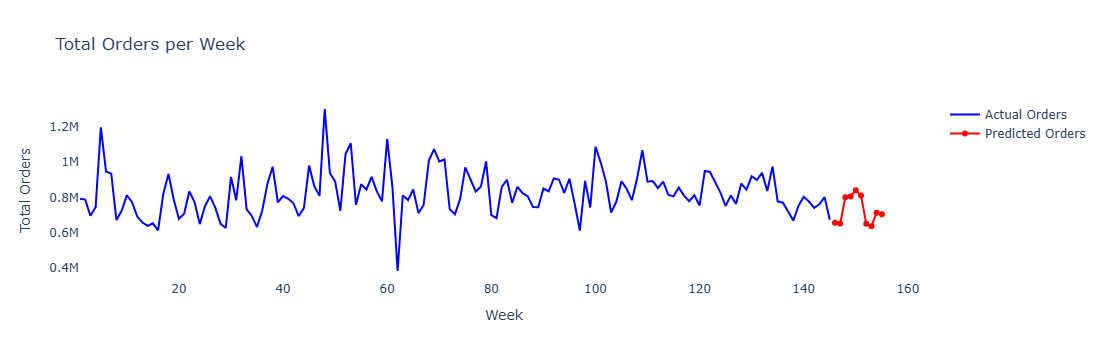

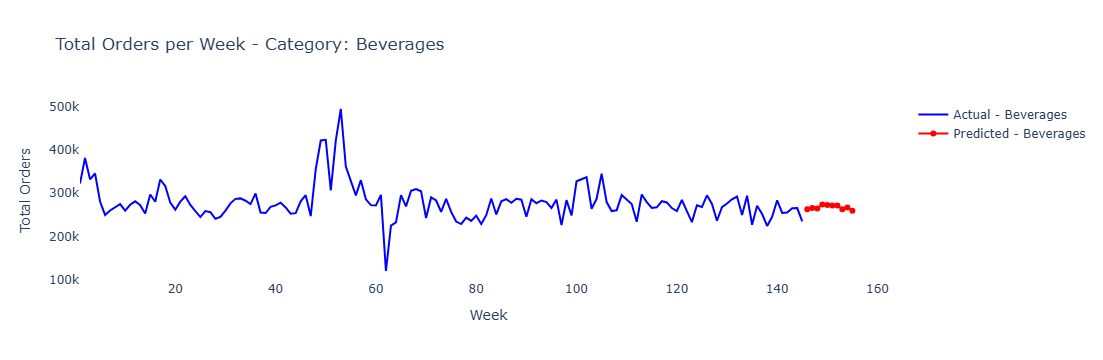

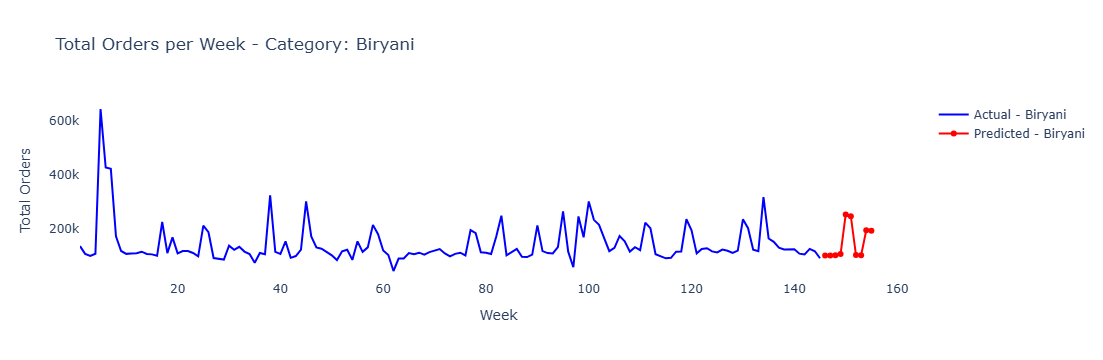

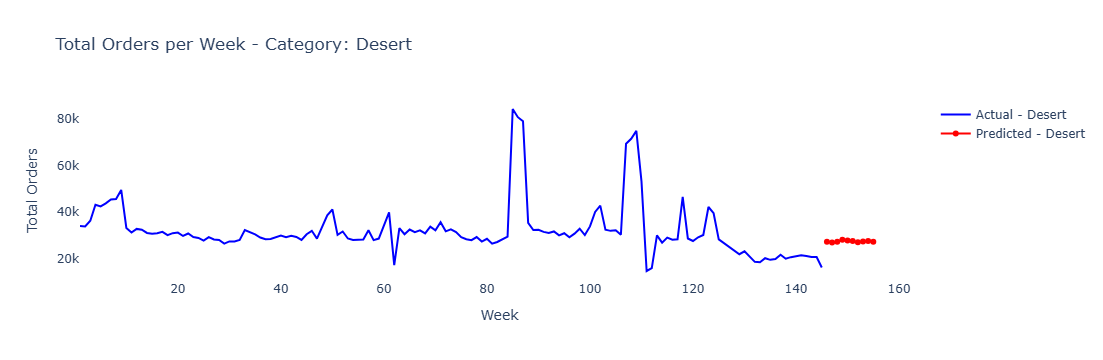

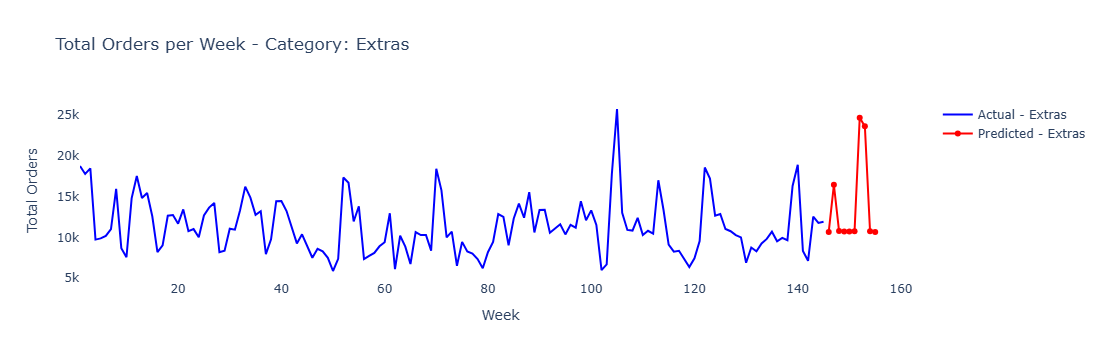

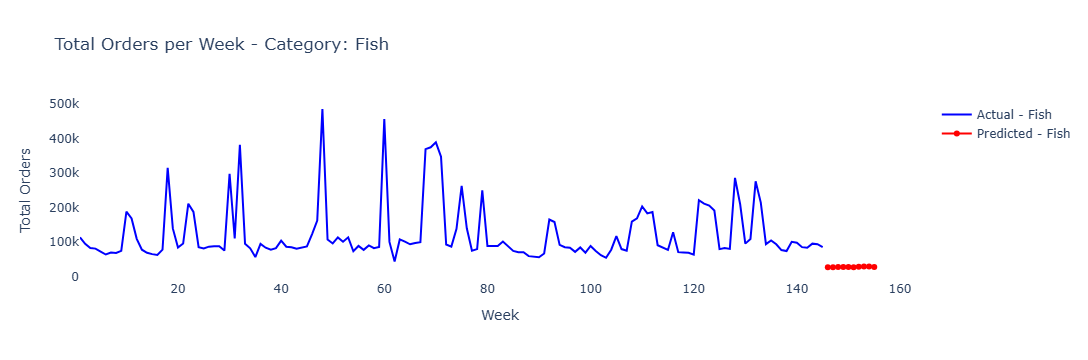

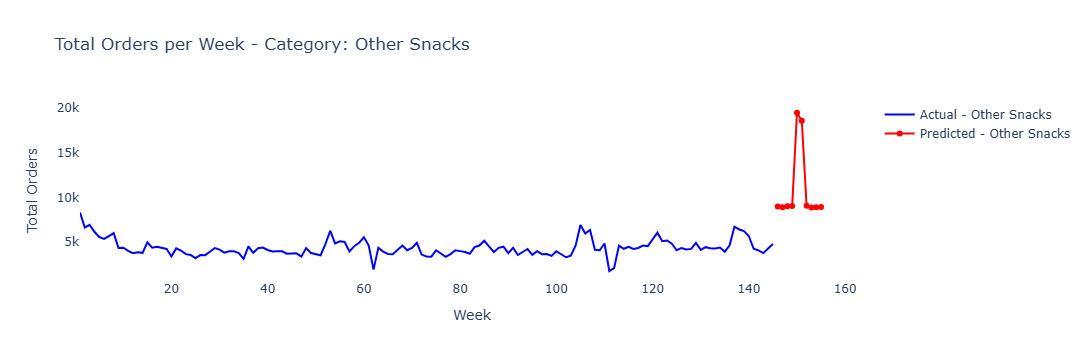

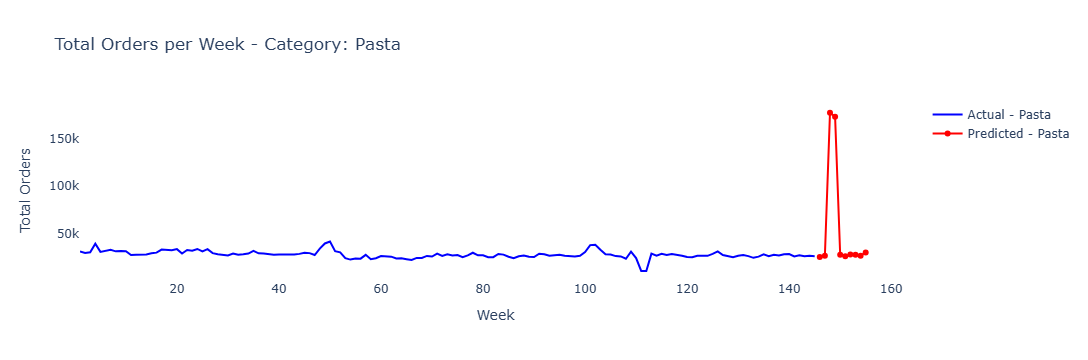

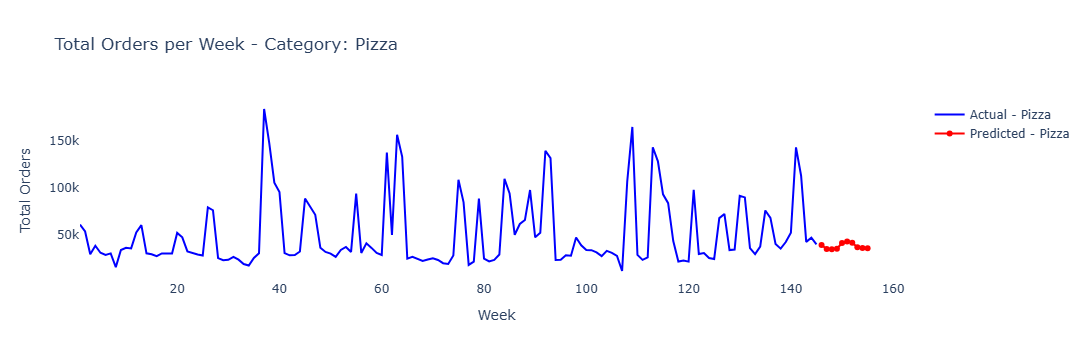

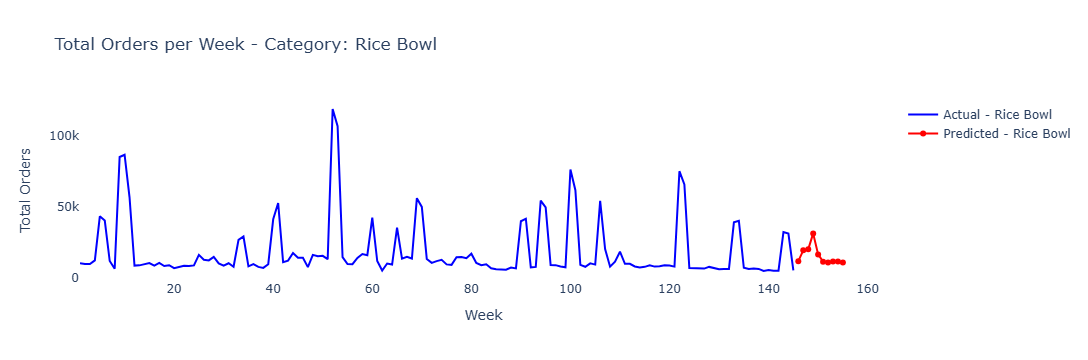

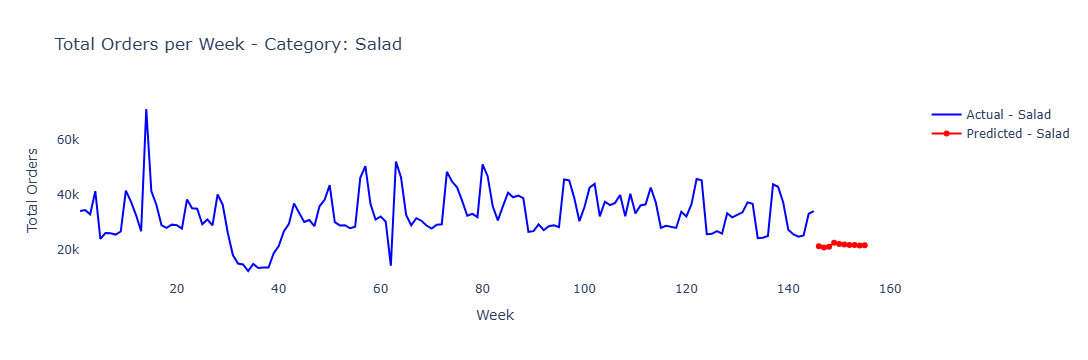

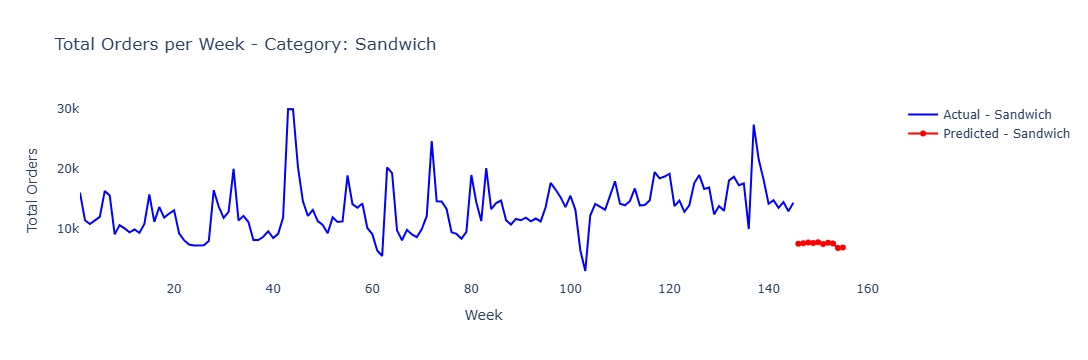

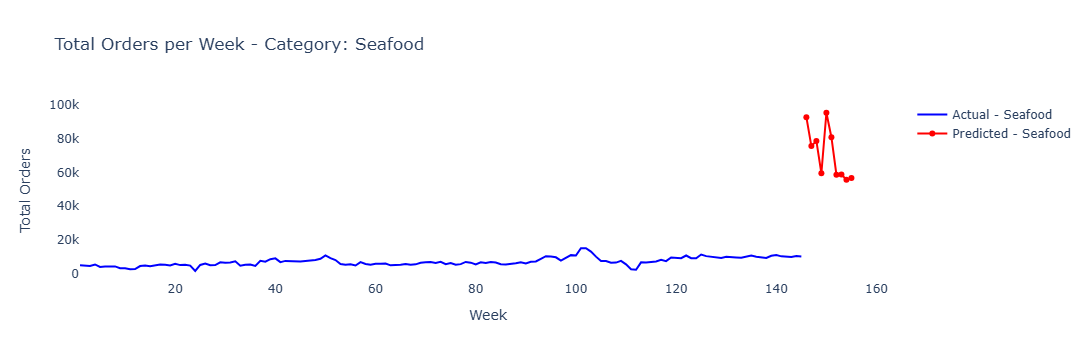

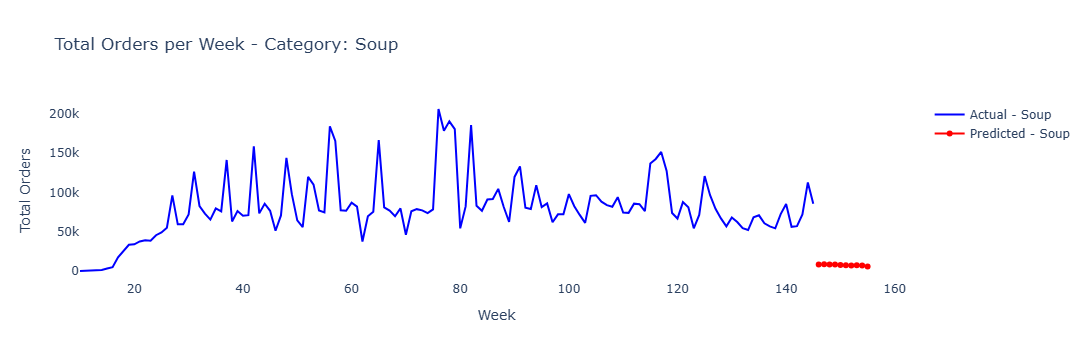

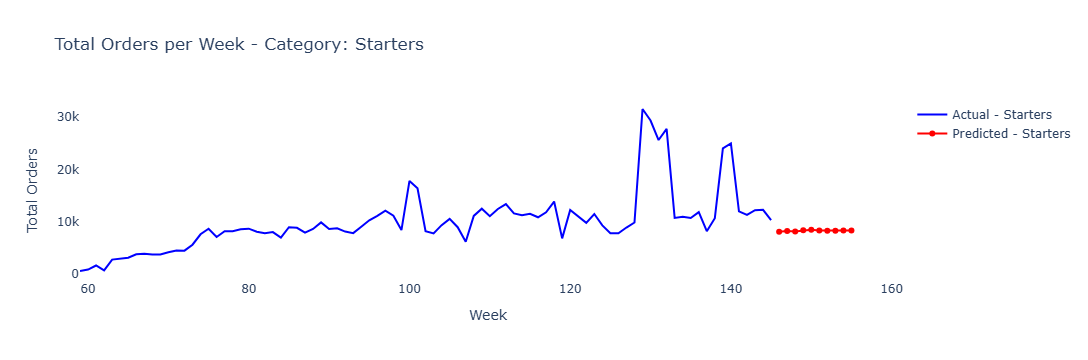

In [25]:
import plotly.graph_objs as go
import plotly.offline as pyoff
pyoff.init_notebook_mode(connected=True)

# Reconstruct the categorical mapping to label categories in plots
category_labels = [
    "Beverages", "Biryani", "Desert", "Extras", "Fish", "Other Snacks",
    "Pasta", "Pizza", "Rice Bowl", "Salad", "Sandwich", "Seafood", "Soup", "Starters"
]
cat_mapping = {i: name for i, name in enumerate(category_labels)}

# Predict using the best model (BiLSTM)
ypred = bilstm_model.predict(test_reshaped)

# Total orders actual
ts_tot_orders = df.groupby(['week'])['num_orders'].sum().reset_index()

# Combine predictions with test data
ypred_df = pd.DataFrame(ypred, columns=['predicted_orders'])
test_reset = test.reset_index(drop=True)
predictions = pd.concat([test_reset, ypred_df], axis=1)

# Total predicted orders per week
ts_tot_pred = predictions.groupby(['week'])['predicted_orders'].sum().reset_index()

# Total orders line plot
plot_data = [
    go.Scatter(x=ts_tot_orders['week'], y=ts_tot_orders['num_orders'], name='Actual Orders', marker=dict(color='blue')),
    go.Scatter(x=ts_tot_pred['week'], y=ts_tot_pred['predicted_orders'], name='Predicted Orders', marker=dict(color='red'))
]

plot_layout = go.Layout(
    title='Total Orders per Week',
    yaxis_title='Total Orders',
    xaxis_title='Week',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Category-wise actual vs predicted
ts_cat_pred = predictions.groupby(['week', 'category'])['predicted_orders'].sum().reset_index()
ts_cat_actual = df.groupby(['week', 'category'])['num_orders'].sum().reset_index()

# Plot category-wise graphs
categories = ts_cat_actual['category'].unique()
for category in categories:
    cat_name = cat_mapping.get(category, f'Category {category}')
    
    plot_data = [
        go.Scatter(
            x=ts_cat_actual[ts_cat_actual['category'] == category]['week'],
            y=ts_cat_actual[ts_cat_actual['category'] == category]['num_orders'],
            name=f'Actual - {cat_name}',
            line=dict(color='Blue')
        ),
        go.Scatter(
            x=ts_cat_pred[ts_cat_pred['category'] == category]['week'],
            y=ts_cat_pred[ts_cat_pred['category'] == category]['predicted_orders'],
            name=f'Predicted - {cat_name}',
            line=dict(color='Red')
        )
        
    ]

    plot_layout = go.Layout(
        title=f'Total Orders per Week - Category: {cat_name}',
        yaxis_title='Total Orders',
        xaxis_title='Week',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig = go.Figure(data=plot_data, layout=plot_layout)
    pyoff.iplot(fig)
